# 08: Modflow-setup demonstration

[Modflow-setup](https://github.com/DOI-USGS/modflow-setup) is a Python package for automating construction of MODFLOW  models from grid-independent source data including shapefiles, rasters, and other MODFLOW models that are geo-located. Input data and model construction options are summarized in a single configuration file in the [YAML](https://en.wikipedia.org/wiki/YAML) format. Source data are read from their native formats and mapped to a regular finite difference grid specified in the configuration file. An external array-based Flopy model instance with the desired packages is created from the sampled source data and configuration settings. Since every modeling problem is different, the Flopy model instance can be further modified in the same script, using Flopy or other Python packages. MODFLOW input can then be written from the flopy model instance.

## Example problem
Here we use Modflow-setup to make an inset model within the Pleasant Lake example model illustrated in exercise [03: Loading and visualizing groundwater models](solutions/03_Loading_and_visualizing_models-solutions.ipynb). 
* The inset model will be the same as the "parent" model, except 
* the layer top and bottom elevations, head observations and Lake and SFR Package boundary conditions will be re-discretized horizontally on a finer grid. 
    * The Streamflow Routing (SFR) Packages is constructed from a [NHDPlus v2 dataset](https://nhdplus.com/NHDPlus/NHDPlusV2_data.php)
    * The Lake package is created from a polygon feature, bathymetry raster, stage-area-volume file and climate data from [PRISM](https://prismodel.oregonstate.edu/).
    * Lake package observations are set up automatically (with an output file for each lake)
    * Layer 1 in the parent model is subdivided into layers 1 and 2 in the inset model
    * Head observations are (re)specified from csv files
* Array inputs to the RCHa, NPF, STO Packages will be resampled (interpolated) from the parent model to the inset model grid. 
* Pumping (Well Package) wells represented in the parent model will be mapped to the nearest cell center in the inset model.

As we'll see below, Modflow-setup does all of this automatically, based on input specified in a configuration file.


**Note:**  
The example here is presented in an interactive Jupyter Notebook format for illustrative purposes. Typically, the best way to use Modflow-setup is within a python script (`*.py` file) that runs from start to finish. To get started with Modflow-setup on your project, see the [10 Minutes to Modflow-setup](https://doi-usgs.github.io/modflow-setup/latest/10min.html) guide, which includes template configuration files and model build scripts that you can download.



## Part 1) The configuration file

The configuration file is the primary vehicle of user input to Modflow-setup. The goal is to have a human and machine-readable document that concisely summarizes the data sources and construction methods/options for the basic model structure prior to parameter estimation. Input is specified in the [YAML](https://en.wikipedia.org/wiki/YAML) format, which is analogous to a Python dictionary but with nesting indicated by indention instead of curly braces. 

* More about YAML [here](https://doi-usgs.github.io/modflow-setup/config-file.html).
* A template configuration file to get started with is available [here](https://doi-usgs.github.io/modflow-setup/10min.html#make-a-minimum-working-configuration-file-and-model-build-script).

### Contents of `data/pleasant.yml`:

```yaml
# input for MODFLOW 6 simulation
simulation:
  sim_name: 'pleasant-inset'
  version: 'mf6'
  sim_ws: 'pleasant-inset/'

# input for MODFLOW 6 model
model:
  simulation: 'pleasant-inset'
  modelname: 'pleasant-inset'
  options:
    print_input: True
    save_flows: True
    newton: True
    newton_under_relaxation: True
  # packages to build
  # (any packages not listed or commented out will not be built,
  #  event if they have an input block below)
  packages: ['dis',
             'ic',
             'npf',
             'oc',
             'sto',
             # Note: with no recharge block below and default_source_data=True, 
             # recharge is regridded from parent model
             'rch', 
             'sfr',
             'lak',
             'obs',
             'wel',
             'ims',
             'chd'
  ]

# Regional model to extract boundary conditions, property arrays, and pumping data from
parent:
  # arguments to flopy.modflow.Modflow.load for parent model
  namefile: 'pleasant.nam'
  model_ws: 'pleasant-lake/'
  version: 'mf6'
  # modflow-setup options
  # default_source_data: True, packages and variables that are omitted 
  # will be pulled from the parent model
  default_source_data: True  
  copy_stress_periods: 'all'
  inset_layer_mapping:  # mapping between inset and parent model layers
    0: 0  # inset: parent  (inset layers 1 and 0 copied from parent layer 0)
    1: 0
    2: 1
    3: 2
    4: 3
  start_date_time: '2012-01-01'
  length_units: 'meters'
  time_units: 'days'
  SpatialReference:
    xoff: 552400
    yoff: 387200
    epsg: 3070

# parameters for setting up the horizontal configuration of the grid
setup_grid:
  xoff: 553200 # lower left x-coordinate
  yoff: 387800 # lower left y-coordinate
  rotation: 0.
  dxy: 50  # uniform cell spacing, in CRS units of meters
  crs: 3070  # Coordinate reference system (Wisconsin Transverse Mercator)

# Structured Discretization Package
dis:
  options:
    length_units: 'meters'
  dimensions:
    nlay: 5
    nrow: 100
    ncol: 108
  source_data:
    top:
      # DEM file; path relative to setup script
      filename: 'pleasant-lake/source_data/rasters/dem40m.tif'
      elevation_units: 'meters'
    botm:
      filenames:  # preprocessed layer surfaces
        1: 'pleasant-lake/source_data/rasters/botm0.tif'
        2: 'pleasant-lake/source_data/rasters/botm1.tif'
        3: 'pleasant-lake/source_data/rasters/botm2.tif'
        4: 'pleasant-lake/source_data/rasters/botm3.tif'

# Temporal Discretization Package
tdis:
  options:
    time_units: 'days'
    start_date_time: '2012-01-01'
  perioddata:
    # time discretization info can be specified directly under the perioddata key
    # or in groups of stress periods that are discretized in a similar way
    group 1: # initial steady-state period (steady specified under sto package)
      #perlen: 1 # Specify perlen as an int or list of lengths in model units, 
      # or perlen=None and 3 of start_date, end_date, nper and/or freq."
      nper: 1
      nstp: 1
      tsmult: 1
      # "steady" can be entered here; 
      # otherwise the global entry specified in the STO package is used as the default
      steady: True  
      # oc_saverecord: can also be specified by group here; 
      # otherwise the global entry specified in the oc package is used as the default
    group 2: # monthly stress periods
      # can be specified by group, 
      # otherwise start_date_time for the model (under tdis: options) will be used.
      start_date_time: '2012-01-01'  
      # model ends at midnight on this date (2012-12-31 would be the last day simulated)
      end_date_time: '2013-01-01'
      freq: '1MS'  # see arguments to pandas.date_range
      nstp: 1
      tsmult: 1.5
      steady: False

# Initial Conditions Package
ic:
  source_data:
    strt:
      from_parent:   # starting heads sampled from parent model
        binaryfile: 'pleasant-lake/pleasant.hds'
        stress_period: 0

# Node Property Flow Package
npf:
  options:
    save_flows: True
  griddata:
    icelltype: 1 # variable sat. thickness in all layers
  # with parent: default_source_data: True,
  # unspecified variables such as "k" and "k33" are resampled from parent model

# Storage Package
sto:
  options:
    save_flows: True
  griddata:
    iconvert: 1  # convertible layers
  # with parent: default_source_data: True,
  # unspecified variables such as "sy" and "ss" are resampled from parent model

# Well Package
wel:
  options:
    print_input: True
    print_flows: True
    save_flows: True
  # with parent: default_source_data: True,
  # unspecified well fluxes are resampled from parent model

# Streamflow Routing Package
# SFR input is created using SFRmaker (https://github.com/doi-usgs/sfrmaker)
sfr:
  options:
    save_flows: True
  source_data:
    flowlines:
      # path to NHDPlus version 2 dataset
      nhdplus_paths: ['pleasant-lake/source_data/shps']
    # if a DEM is included, streambed top elevations will be sampled
    # from the minimum DEM values within a 100 meter buffer around each stream reach
    dem:
      filename: 'pleasant-lake/source_data/rasters/dem40m.tif'
      elevation_units: 'meters'
    # SFR observations can be automatically setup from a CSV file
    # of x, y locations and fluxes
    observations:  # see sfrmaker.observations.add_observations for arguments
      filename: 'pleasant-lake/source_data/tables/gages.csv'
      obstype: 'downstream-flow'  # modflow-6 observation type
      x_location_column: 'x'
      y_location_column: 'y'
      obsname_column: 'site_no'
  sfrmaker_options:
    # the sfrmaker_options: block can include arguments 
    # to the Lines.to_sfr method in SFRmaker 
    # or other options such as set_streambed_top_elevations_from_dem
    # or to_riv (see SFRmaker and Modflow-setup docs)
    set_streambed_top_elevations_from_dem: True

# Lake Package
lak:
  options:
    boundnames: True
    save_flows: True
    surfdep: 0.1  
  source_data:
    # initial lakebed leakance rates
    littoral_leakance: 0.045 # for thin zone around lake perimeter; 1/d
    profundal_leakance: 0.025 # for interior of lake basin; 1/d
    littoral_zone_buffer_width: 40
    lakes_shapefile:  # polygon shapefile of lake footprints
      filename: 'pleasant-lake/source_data/shps/all_lakes.shp'
      id_column: 'HYDROID'
      include_ids: [600059060] # pleasant lake
    # setup lake precipitation and evaporation from PRISM data
    climate:
      filenames:
        600059060: 'pleasant-lake/source_data/PRISM_ppt_tmean_stable_4km_189501_201901_43.9850_-89.5522.csv'
      format: 'prism'
      period_stats:
        # for period 0, use average precip and evap for dates below
        0: ['mean', '2012-01-01', '2018-12-31']  # average daily rate for model period for initial steady state
        # for subsequent periods,
        # average precip and evap to period start/end dates
        1: 'mean'  # average daily rate or value for each month
    # bathymetry file with lake depths to subtract off model top
    bathymetry_raster:
      filename: 'pleasant-lake/source_data/rasters/pleasant_bathymetry.tif'
      length_units: 'meters'
    # bathymetry file with stage/area/volume relationship
    stage_area_volume_file:
      filename: 'pleasant-lake/source_data/tables/area_stage_vol_Pleasant.csv'
      length_units: 'meters'
      id_column: 'hydroid'
      column_mappings:
        volume_m3: 'volume'
  external_files: False  # option to write connectiondata table to external file

# Iterative model solution
ims:
  options:
    complexity: 'complex'
  nonlinear:
    outer_dvclose: 1.e-1
    outer_maximum: 200

# Observation (OBS) Utility
obs:
  source_data:
    # Head observations are supplied via csv files 
    # with x, y locations and observation names
    # an observation is generated in each model layer;
    # observations at each location can subsequently be processed
    # to represent a given screened interval
    # for example, using modflow-obs (https://github.com/aleaf/modflow-obs)
    filenames: ['pleasant-lake/source_data/tables/nwis_heads_info_file.csv',
                'pleasant-lake/source_data/tables/lake_sites.csv',
                'pleasant-lake/source_data/tables/wdnr_gw_sites.csv',
                'pleasant-lake/source_data/tables/uwsp_heads.csv',
                'pleasant-lake/source_data/tables/wgnhs_head_targets.csv'
                     ]
    column_mappings:
      obsname: ['obsprefix', 'obsnme', 'common_name']
  drop_observations: ['10019209_lk'  # pleasant lake; monitored via Lake Package observations
  ]

# Perimeter boundary condition of heads extracted from parent model solution
chd:
  perimeter_boundary:
    parent_head_file: 'pleasant-lake/pleasant.hds'
```

## Part 2) The model build script

A template model build script that can be further customized for your project is available [here](https://doi-usgs.github.io/modflow-setup/10min.html#make-a-minimum-working-configuration-file-and-model-build-script).


In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib import patheffects
import flopy
from mfsetup import MF6model

### Define some functions

#### A function to just make a model grid
Oftentimes at the start of a modeling project, we want to quickly test different grid resolutions and extents before attempting to build the model. We can do this with Modflow-setup by creating a model instance and then running the ``setup_grid()`` method. A Flopy-like model grid instance is created from the ``setup_grid:`` block in the configuration file. 

Wrapping this in a function helps to
1) keep the `__main__` part of the script clean and concise, and 
2) also provides a more robust way to control the current working directory (`cwd`). Modflow-setup changes the `cwd` to the specified model workspace (`model_ws:` specified above), to more easily work with external (MODFLOW) input files through the Flopy interface.

In [2]:
def setup_grid(configuration_file):
    """Just set up (a shapefile of) the model grid.
    For trying different grid configurations."""
    cwd = os.getcwd()
    model = MF6model(cfg=configuration_file)
    model.setup_grid()
    model.modelgrid.write_shapefile('postproc/shps/grid.shp')
    os.chdir(cwd)
    return model

#### A function to build the model using Modflow-setup

In [3]:
def setup_model(configuration_file):
    """Set up the whole model."""
    cwd = os.getcwd()
    model = MF6model.setup_from_yaml(configuration_file)
    model.write_input()
    os.chdir(cwd)
    return model

### Specify the model configuration file
Read the model workspace location and model name from the configuration file, so that we only have to specify them there.

In [4]:
import yaml

model_configuration_file = Path('data/pleasant.yml')
# Load the model configuration file into a dictionary
with open(model_configuration_file) as src:
    cfg = yaml.load(src, Loader=yaml.Loader)

sim_ws = model_configuration_file.parent / cfg['simulation']['sim_ws']
model_name = cfg['model']['modelname']

### Just make a model grid


In [5]:
%%capture
model = setup_grid('data/pleasant.yml')

(552400.0, 559200.0)

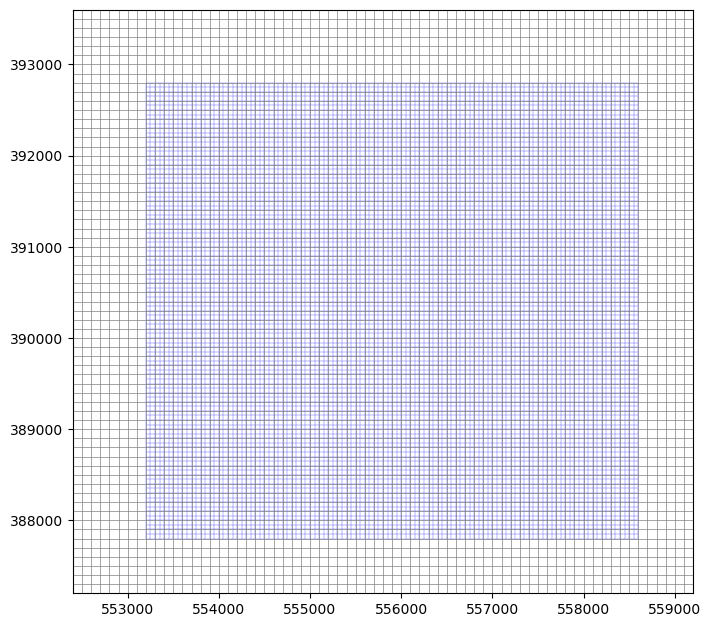

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
model.modelgrid.plot(ax=ax, zorder=2, ec='b', lw=0.2)
model.parent.modelgrid.plot(ax=ax, lw=0.5)
ax.set_ylim(*model.parent.modelgrid.bounds[1::2])
ax.set_xlim(*model.parent.modelgrid.bounds[::2])


In [7]:
parent_model = model.parent
parent_model.modelgrid.write_shapefile(sim_ws / 'postproc/shps/regional_model_grid.shp')

creating shapely Polygons of grid cells...
finished in 0.17s



writing data/pleasant-inset/postproc/shps/regional_model_grid.shp... Done


### Build the whole model

In [8]:
%%capture
model = setup_model('data/pleasant.yml')

a ``MF6model`` instance (subclass of ``flopy.mf6.ModflowGwf``) is returned

In [9]:
model

Pleasant Lake test case version 0.1.post561.dev0+g4aedfab
Parent model: /home/runner/work/python-for-hydrology/python-for-hydrology/docs/source/notebooks/part1_flopy/data/pleasant-lake//pleasant
5 layer(s), 100 row(s), 108 column(s)
delr: [50.00...50.00] undefined
delc: [50.00...50.00] undefined
CRS: EPSG:3070
length units: meters
xll: 553200.0; yll: 387800.0; rotation: 0.0
Bounds: (np.float64(553200.0), np.float64(558600.0), np.float64(387800.0), np.float64(392800.0))
Packages: dis ic npf sto rcha_0 oc chd_0 obs_0 sfr_0 lak_0 obs_1 wel_0 obs_2 obs_3
13 period(s):
 per start_datetime end_datetime  perlen  steady  nstp
   0     2012-01-01   2012-01-01     1.0    True     1
   1     2012-01-01   2012-02-01    31.0   False     1
   2     2012-02-01   2012-03-01    29.0   False     1
   ...
  12     2012-12-01   2013-01-01    31.0   False     1

information from the configuration file is stored in an attached ``cfg`` dictionary

In [10]:
model.cfg.keys()

dict_keys(['metadata', 'simulation', 'model', 'parent', 'postprocessing', 'setup_grid', 'dis', 'tdis', 'ic', 'npf', 'sto', 'rch', 'sfr', 'high_k_lakes', 'lak', 'mvr', 'chd', 'drn', 'ghb', 'riv', 'wel', 'oc', 'obs', 'ims', 'mfsetup_options', 'filename', 'maw', 'external_files', 'intermediate_data', 'grid'])

the ``cfg`` dictionary contains both information from the configuration file, and MODFLOW input (such as external text file arrays) that was developed from the original source data. Internally in Modflow-setup, MODFLOW input in ``cfg`` is fed to the various Flopy object constructors.

In [11]:
model.cfg['dis']

defaultdict(dict,
            {'remake_top': True,
             'options': {'length_units': 'meters'},
             'dimensions': {'nlay': 5, 'nrow': 100, 'ncol': 108},
             'griddata': {'top': [{'filename': './external/top.dat'}],
              'botm': [{'filename': './external/botm_000.dat'},
               {'filename': './external/botm_001.dat'},
               {'filename': './external/botm_002.dat'},
               {'filename': './external/botm_003.dat'},
               {'filename': './external/botm_004.dat'}],
              'idomain': [{'filename': './external/idomain_000.dat'},
               {'filename': './external/idomain_001.dat'},
               {'filename': './external/idomain_002.dat'},
               {'filename': './external/idomain_003.dat'},
               {'filename': './external/idomain_004.dat'}]},
             'top_filename_fmt': 'top.dat',
             'botm_filename_fmt': 'botm_{:03d}.dat',
             'idomain_filename_fmt': 'idomain_{:03d}.dat',
       

#### Plot the model grid with Lake Package connections by layer

Text(0, 0.5, 'Northing, in WTM meters (epsg: 3070)')

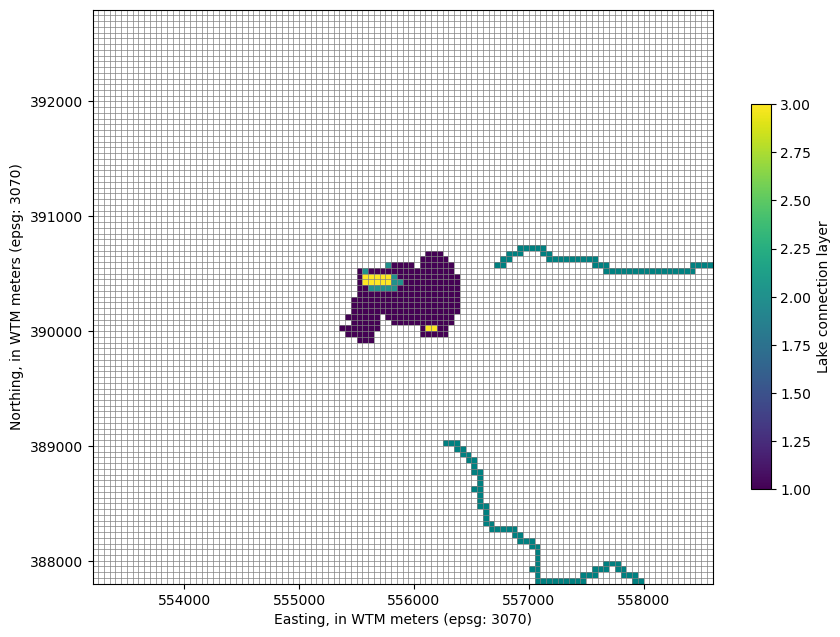

In [12]:
# Get the parent model grid extent
# to set plot limits later
modelgrid = model.modelgrid
l, r, b, t = modelgrid.extent

# Make the plot
fig, ax = plt.subplots(figsize=(10, 10))
mv = flopy.plot.PlotMapView(model=model, ax=ax)
mv.plot_bc("SFR", plotAll=True)
lcp = mv.plot_grid(lw=0.5, ax=ax)

# Get the lake connections
vconn = model.lak.connectiondata.array[model.lak.connectiondata.array['claktype'] == 'vertical']
k, i, j = zip(*vconn['cellid'])
lakeconnections = np.zeros((modelgrid.nrow, modelgrid.ncol))
lakeconnections[i, j] = np.array(k) + 1
lakeconnections = np.ma.masked_array(lakeconnections, mask=lakeconnections == 0)
qmi = mv.plot_array(lakeconnections)

# re-limit the plot to the parent model extent
ax.set_ylim(b, t)
ax.set_xlim(l, r)
ax.set_aspect(1)
plt.colorbar(qmi, shrink=0.5, label='Lake connection layer')
ax.set_xlabel('Easting, in WTM meters (epsg: 3070)')
ax.set_ylabel('Northing, in WTM meters (epsg: 3070)')

### Run the model
* we already wrote the input above in the `setup_model()` function (while the working directory was set to the model workspace)

**Note:** Running the model through Flopy (as below) requires specification of the MODFLOW executable. In Flopy, the executable is specified via the ``exe_name`` argument to the simulation constructor for MODFLOW 6, or model constructor for previous MODFLOW versions. Similarly, in Modflow-setup, the ``exe_name`` is specified in the ``simulation:`` or ``model:`` block of the [configuration file](https://doi-usgs.github.io/modflow-setup/latest/config-file-gallery.html#pleasant-lake-test-case). This example assumes that a MODFLOW 6 executable with the name "mf6" either resides in the model workspace, or is included in the system path.

In [13]:
model.simulation.run_simulation()

FloPy is using the following executable to run the model: ../../../../../../../../../.local/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.2 05/12/2025

   MODFLOW 6 compiled May 24 2025 11:41:46 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor th

    Solving:  Stress period:     2    Time step:     1


    Solving:  Stress period:     3    Time step:     1


    Solving:  Stress period:     4    Time step:     1


    Solving:  Stress period:     5    Time step:     1


    Solving:  Stress period:     6    Time step:     1


    Solving:  Stress period:     7    Time step:     1


    Solving:  Stress period:     8    Time step:     1


    Solving:  Stress period:     9    Time step:     1


    Solving:  Stress period:    10    Time step:     1


    Solving:  Stress period:    11    Time step:     1


    Solving:  Stress period:    12    Time step:     1


    Solving:  Stress period:    13    Time step:     1


 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/09/26 14:24:44
 Elapsed run time:  6.766 Seconds
 

WARNING REPORT:

  1. OPTIONS BLOCK VARIABLE 'UNIT_CONVERSION' IN FILE 'pleasant-inset.sfr'
     WAS DEPRECATED IN VERSION 6.4.2. SETTING UNIT_CONVERSION DIRECTLY.
 Normal termination of simulation.


(True, [])

### Plot the results


#### Read the output and post-process the 3D head results into a 2D water table

In [14]:
import flopy.utils.binaryfile as bf
from flopy.utils.postprocessing import get_water_table

headfile_object = bf.HeadFile(sim_ws / 'pleasant-inset.hds')

# read the head results for the last stress period
kper = 12
heads = headfile_object.get_data(kstpkper=(0, kper))

# Get the water table elevation from the 3D head results
water_table = get_water_table(heads)

# put in the lake level (not included in head output)
lake_results = pd.read_csv(sim_ws / 'lake1.obs.csv')
stage = lake_results['STAGE'][kper]
cnd = pd.DataFrame(model.lak.connectiondata.array)
k, i, j = zip(*cnd['cellid'])
water_table[i, j] = stage

# add the SFR stage as well
sfr_stage = model.sfr.output.stage().get_data()[0, 0, :]
# get the SFR cell i, j locations
# by unpacking the cellid tuples in the packagedata
sfr_k, sfr_i, sfr_j = zip(*model.sfr.packagedata.array['cellid'])
water_table[sfr_i, sfr_j] = sfr_stage

# get the cell budget using the .output attribute
# (instead of the binaryfile utility directly)
cbc = model.output.budget()
lake_fluxes = cbc.get_data(text='lak', full3D=True)[0].sum(axis=0)
sfr_fluxes = cbc.get_data(text='sfr', full3D=True)[0]

### Make the plot
* show "leakage" results for the Lake and SFR packages (neg. values indicate groundwater discharge to surface water)

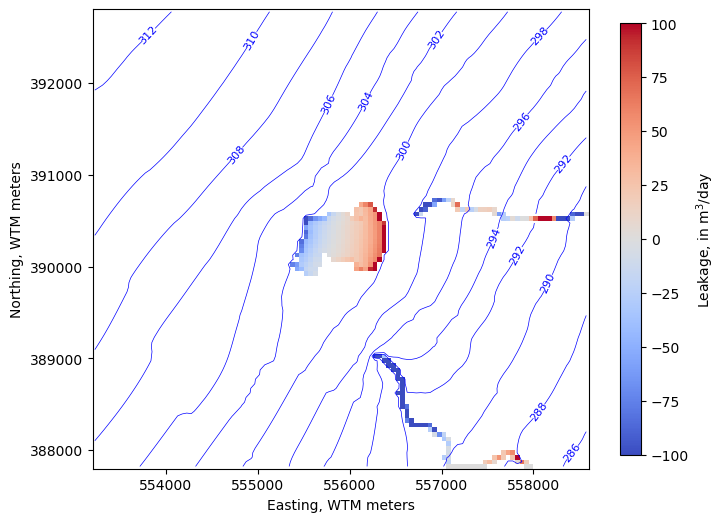

In [15]:
levels=np.arange(280, 315, 2)

fig, ax = plt.subplots(figsize=(8, 8))
pmv = flopy.plot.PlotMapView(model, ax=ax)
ctr = pmv.contour_array(water_table, levels=levels, 
                        linewidths=.5, colors='b')
labels = pmv.ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=1)
vmin, vmax = -100, 100
im = pmv.plot_array(lake_fluxes, cmap='coolwarm', vmin=vmin, vmax=vmax)
im = pmv.plot_array(sfr_fluxes.sum(axis=0), cmap='coolwarm', vmin=vmin, vmax=vmax)
cb = fig.colorbar(im, shrink=0.7, label='Leakage, in m$^3$/day')
ax.set_ylabel("Northing, WTM meters")
ax.set_xlabel("Easting, WTM meters")
ax.set_aspect(1)

### What if we want to further customize the model?

**Add a high-capacity pumping well at a specified location**, using the Multi-Aquifer Well (MAW) Package, which isn't yet supported by Modflow-setup

In [16]:
well_x, well_y = 556000, 389500
# get the row, column location from the coordinates
well_i, well_j = model.modelgrid.intersect(well_x, well_y)
well_i, well_j

(np.int64(65), np.int64(55))

Set up the MAW Package

In [17]:
#wellno radius bottom strt condeqn ngwfnodes boundname
packagedata = [[0, 0.25, 274, 296., 'mean', 4, 'new_well']]
#wellno icon k i j scrn_top scrn_botm hk_skin radius_skin
connectiondata = [
    [0, 0, 0, well_i, well_j, 299, 274, 100.0, 0.7],
    [0, 1, 1, well_i, well_j, 299, 274, 100.0, 0.7],
    [0, 2, 2, well_i, well_j, 299, 274, 100.0, 0.7],
    [0, 3, 3, well_i, well_j, 299, 274, 100.0, 0.7]
    ]
perioddata_input = [[0, "rate", -2000*1440/264.17]]

maw = flopy.mf6.ModflowGwfmaw(
    model,
    boundnames=True,
    save_flows=True,
    packagedata=packagedata,
    connectiondata=connectiondata,
    perioddata=perioddata_input,
    pname='maw'
    )

Write the MAW Package input file;

Refresh the Name file to include the MAW Package

In [18]:
model.maw.write()
# refresh the name file with the added package
model.name_file.write()

INFORMATION: nmawwells in ('gwf6', 'maw', 'dimensions') changed to 1 based on size of packagedata


In [19]:
model.simulation.run_simulation()

FloPy is using the following executable to run the model: ../../../../../../../../../.local/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.2 05/12/2025

   MODFLOW 6 compiled May 24 2025 11:41:46 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor th

    Solving:  Stress period:     2    Time step:     1


    Solving:  Stress period:     3    Time step:     1


    Solving:  Stress period:     4    Time step:     1


    Solving:  Stress period:     5    Time step:     1


    Solving:  Stress period:     6    Time step:     1


    Solving:  Stress period:     7    Time step:     1


    Solving:  Stress period:     8    Time step:     1


    Solving:  Stress period:     9    Time step:     1


    Solving:  Stress period:    10    Time step:     1


    Solving:  Stress period:    11    Time step:     1


    Solving:  Stress period:    12    Time step:     1


    Solving:  Stress period:    13    Time step:     1


 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/09/26 14:24:52
 Elapsed run time:  7.846 Seconds
 

WARNING REPORT:

  1. The screen tops in multi-aquifer well package MAW were reset to the top
     of the connected cell 3 times.
  2. The screen bottoms in multi-aquifer well package MAW were reset to the
     bottom of the connected cell 3 times.
  3. OPTIONS BLOCK VARIABLE 'UNIT_CONVERSION' IN FILE 'pleasant-inset.sfr'
     WAS DEPRECATED IN VERSION 6.4.2. SETTING UNIT_CONVERSION DIRECTLY.
 Normal termination of simulation.


(True, [])

### Plot the simulated drawdown

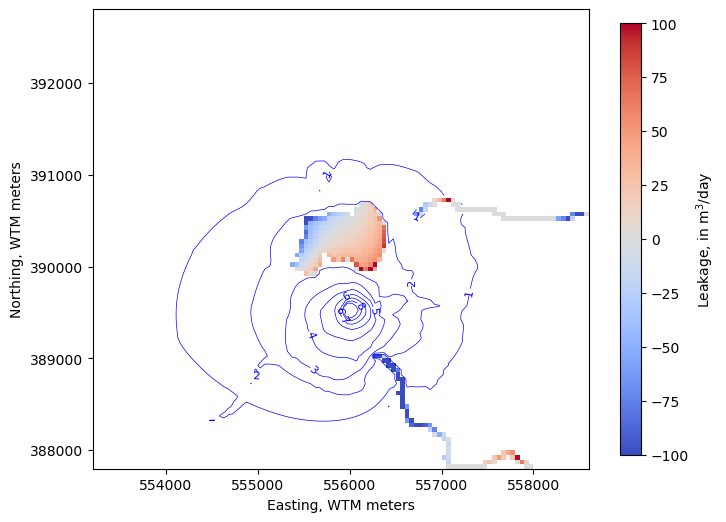

In [20]:
heads2 = headfile_object.get_data(kstpkper=(0, kper))


water_table2 = get_water_table(heads2)
lake_results = pd.read_csv(sim_ws / 'lake1.obs.csv')
stage = lake_results['STAGE'][kper]
cnd = pd.DataFrame(model.lak.connectiondata.array)
k, i, j = zip(*cnd['cellid'])
water_table2[i, j] = stage
sfr_stage = model.sfr.output.stage().get_data()[0, 0, :]
sfr_k, sfr_i, sfr_j = zip(*model.sfr.packagedata.array['cellid'])
water_table2[sfr_i, sfr_j] = sfr_stage
drawdown = water_table - water_table2

# get the cell budget using the .output attribute
# (instead of the binaryfile utility directly)
cbc = model.output.budget()
lake_fluxes = cbc.get_data(text='lak', full3D=True)[0].sum(axis=0)
sfr_fluxes = cbc.get_data(text='sfr', full3D=True)[0]

levels=np.arange(1, 10 , 1)

fig, ax = plt.subplots(figsize=(8, 8))
pmv = flopy.plot.PlotMapView(model, ax=ax)
ctr = pmv.contour_array(drawdown, levels=levels, 
                        linewidths=.5, colors='b')
labels = pmv.ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=1)
vmin, vmax = -100, 100
im = pmv.plot_array(lake_fluxes, cmap='coolwarm', vmin=vmin, vmax=vmax)
im = pmv.plot_array(sfr_fluxes.sum(axis=0), cmap='coolwarm', vmin=vmin, vmax=vmax)
cb = fig.colorbar(im, shrink=0.7, label='Leakage, in m$^3$/day')
ax.set_ylabel("Northing, WTM meters")
ax.set_xlabel("Easting, WTM meters")
ax.set_aspect(1)